In [20]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.decomposition import PCA

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

In [5]:
data = pd.read_csv('./data/bike_buyers_clean.csv')

In [6]:
# Columns lists
categorical_cols = ['Marital Status', 'Gender', 'Occupation', 'Home Owner', 'Region', 'Purchased Bike']
ordinal_cols = ['Education', 'Commute Distance']
numerical_cols = ['Income', 'Children', 'Cars', 'Age']

# Create a transformer for each data type
# Transfomer for categorical data based on OHC
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
])

# Encoding of ordinal data
ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['Partial High School', 'High School', 'Partial College', 'Bachelors', 'Graduate Degree'], 
                                           ['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles']])) 
])

# Powertransformer normalises data with the assumtption that data is normaly distributed
numerical_transformer = Pipeline(steps=[
    ("transformer", PowerTransformer())
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


pipeline.fit(data)
transformed_data = pipeline.transform(data)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [7]:
# create a df from transformed data to have a better understanding of data
transformed_df = pd.DataFrame(transformed_data, columns = pipeline.fit(data).get_feature_names_out().tolist())
transformed_df

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,cat__Marital Status_Single,cat__Gender_Male,cat__Occupation_Management,cat__Occupation_Manual,cat__Occupation_Professional,cat__Occupation_Skilled Manual,cat__Home Owner_Yes,cat__Region_North America,cat__Region_Pacific,cat__Purchased Bike_Yes,ord__Education,ord__Commute Distance,num__Income,num__Children,num__Cars,num__Age
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,-0.394012,-0.390951,-1.441223,-0.067828
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,-0.799762,0.771203,-0.277524,0.024350
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.831899,1.567855,0.581853,1.321997
3,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,0.564771,-1.340990,-0.277524,-0.162293
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,-0.799762,-1.340990,-1.441223,-0.673208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.275895,0.260296,0.581853,0.913176
996,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.564771,1.197992,-1.441223,-0.784107
997,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.275895,0.260296,-1.441223,-0.460588
998,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.316118,0.771203,1.288811,-0.460588


In [8]:
# Outliers
detector = ECOD()
detector.fit(transformed_df)
outliers = detector.predict(transformed_df)
transformed_df['outliers'] = outliers

In [9]:
data_no_outliers = transformed_df[transformed_df['outliers']==0].drop(["outliers"], axis = 1)
data_with_outliers = transformed_df.copy().drop(["outliers"], axis = 1)

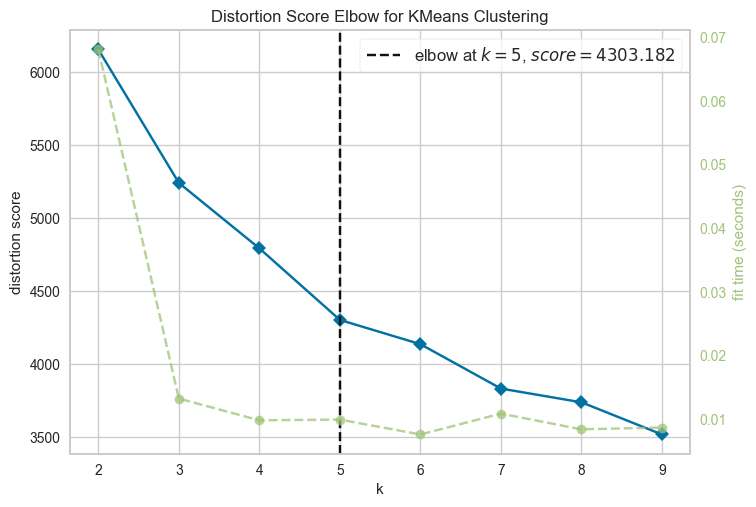

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(data_no_outliers)
visualizer.show()

In [13]:
km = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init = 10)
clusters = km.fit_predict(data_no_outliers)

In [17]:
km.cluster_centers_

array([[ 3.68000000e-01,  4.68000000e-01,  6.40000000e-02,
         2.80000000e-02,  2.56000000e-01,  3.48000000e-01,
         7.72000000e-01,  4.76000000e-01,  8.40000000e-02,
         6.60000000e-01,  3.40800000e+00,  4.32000000e-01,
        -9.81039571e-02, -3.11079647e-01, -1.18542360e+00,
        -2.68819320e-01],
       [ 5.51282051e-01,  4.29487179e-01, -1.11022302e-16,
         4.42307692e-01, -2.77555756e-16,  1.53846154e-01,
         6.02564103e-01,  3.01282051e-01,  8.33333333e-02,
         4.35897436e-01,  1.27564103e+00,  4.42307692e-01,
        -1.08713940e+00,  9.92341318e-02, -7.12802924e-02,
         2.73705357e-03],
       [ 3.73333333e-01,  5.66666667e-01,  4.26666667e-01,
         1.38777878e-17,  4.20000000e-01,  1.53333333e-01,
         6.66666667e-01,  7.53333333e-01,  1.93333333e-01,
         4.73333333e-01,  2.76000000e+00,  9.73333333e-01,
         8.70379338e-01,  6.89101279e-01,  6.54482451e-01,
         3.61315501e-01],
       [ 7.23076923e-01,  5.76923077e

In [16]:
data_no_outliers['cluster'] = clusters

900

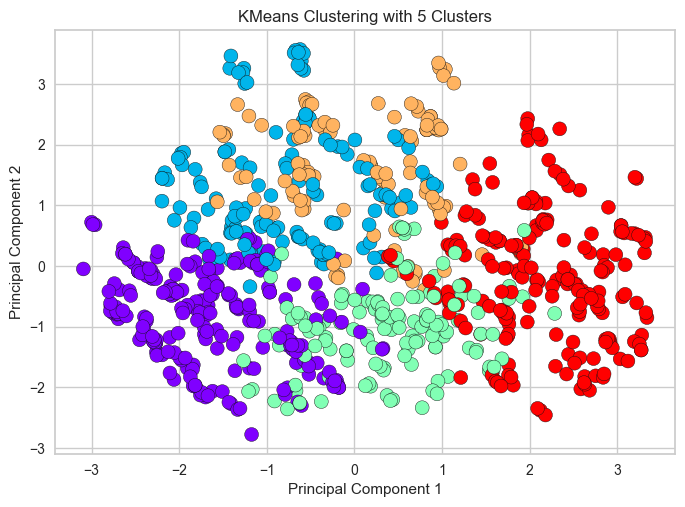

In [21]:
## PCA to reduce dimesnions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 5 Clusters')
plt.show()
